In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = "nnfabrik_v1_tuning"
schema = dj.schema("nnfabrik_v1_tuning")

import os
from os import listdir
from os.path import isfile, join


import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.legacy.from_mei import TrainedEnsembleModel

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

Connecting pawelp@134.2.168.16:3306


In [2]:
TrainedModel()

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,a1e4bdb4771f6b9f14bd9b690123d031,nndichromacy.training.standart_trainer,b4c0c7c93781ae3aa4b502cc9c925b82,1000,max_iter: 100.isotropic.CSRF19_V1,0.364659,=BLOB=,pawelp,2020-11-24 09:00:32
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,a1e4bdb4771f6b9f14bd9b690123d031,nndichromacy.training.standart_trainer,b4c0c7c93781ae3aa4b502cc9c925b82,2000,max_iter: 100.isotropic.CSRF19_V1,0.359621,=BLOB=,pawelp,2020-11-24 09:03:42
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,a1e4bdb4771f6b9f14bd9b690123d031,nndichromacy.training.standart_trainer,b4c0c7c93781ae3aa4b502cc9c925b82,3000,max_iter: 100.isotropic.CSRF19_V1,0.366041,=BLOB=,pawelp,2020-11-24 09:07:29
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,a1e4bdb4771f6b9f14bd9b690123d031,nndichromacy.training.standart_trainer,b4c0c7c93781ae3aa4b502cc9c925b82,4000,max_iter: 100.isotropic.CSRF19_V1,0.364285,=BLOB=,pawelp,2020-11-24 09:10:53
nndichromacy.models.se_core_full_gauss_readout,a09d55344b5793137349b8ca5d17d46d,nndichromacy.datasets.static_loaders,a1e4bdb4771f6b9f14bd9b690123d031,nndichromacy.training.standart_trainer,b4c0c7c93781ae3aa4b502cc9c925b82,5000,max_iter: 100.isotropic.CSRF19_V1,0.364428,=BLOB=,pawelp,2020-11-24 08:48:44
nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,1000,max_iter: 100.isotropic.CSRF19_V1,0.399311,=BLOB=,pawelp,2020-11-23 12:56:36
nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,2000,max_iter: 100.isotropic.CSRF19_V1,0.402584,=BLOB=,pawelp,2020-11-21 15:47:39
nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,3000,max_iter: 100.isotropic.CSRF19_V1,0.396371,=BLOB=,pawelp,2020-11-21 16:34:11
nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,4000,max_iter: 100.isotropic.CSRF19_V1,0.399175,=BLOB=,pawelp,2020-11-21 17:31:20
nnvision.models.se_core_point_readout,f8bcd882c48a55dc6cd6d7afb656f1f9,nnvision.datasets.monkey_static_loader,a737408da40cfedd036c2eb1b8a31ff1,nnvision.training.nnvision_trainer,2a2816c50c67295376b4e89448430985,5000,max_iter: 100.isotropic.CSRF19_V1,0.400873,=BLOB=,pawelp,2020-11-21 18:23:21


In [3]:
# loading model
ensemble_hash = 'e7a8d0b961ee37ffda0779bfed95f1cf'
dataset_hash = 'a737408da40cfedd036c2eb1b8a31ff1'
model_hash = 'f8bcd882c48a55dc6cd6d7afb656f1f9' # monkey
model_hash = 'a09d55344b5793137349b8ca5d17d46d' # mouse

# model_key = (TrainedModel * TrainedEnsembleModel.Member() & dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
model_key = (TrainedModel & dict(model_hash=model_hash)).fetch("KEY", limit=1, order_by="score DESC")
dataloaders, model = TrainedModel().load_model(model_key, include_dataloader=True)
model.eval()

# model specifics for optimization
data_key = '3631807112901' # monkey
data_key = '22564-3-12-0' # mouse
unit_idx = 27
unit_id = 26

# number of model neurons 
n_units = model.readout[data_key].outdims

# image dimensions
w, h = 41, 41 # monkey
w, h = 64, 36 # mouse

next(iter(dataloaders['train'][data_key]))[0].shape

/data/mouse/toliaslab/static/static22564-3-12-preproc0 exists already. Not unpacking /data/mouse/toliaslab/static/static22564-3-12-preproc0.zip


torch.Size([128, 1, 36, 64])

In [53]:
model

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64, bias=False)
          (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (i

In [4]:
# Finite Set
canvas_size         = [w, h]
sizes               = FiniteParameter([float(val) for val in range(5, 31)][::5])
spatial_frequencies = FiniteParameter([float(val) for val in np.linspace(1/80, 2/5, 10)])
contrasts           = FiniteParameter([.5])
orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 10)])
phases              = FiniteParameter([float(val) for val in np.linspace(0.0, 2*np.pi, 10)]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([float(val) for val in np.linspace(0.0, 0.99, 5)])
locations           = FiniteParameter([[float(x), float(y)] for x in range(12, 28) 
                                                            for y in range(12, 28)][::16])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

In [18]:
from ax.service.managed_loop import optimize

def train_evaluate(auto_params, model, data_key, unit_idx):
    """
    Evaluates the activation of a specific neuron in an evaluated (e.g. nnfabrik) model given the bar stimulus
    parameters.

    Args:
        auto_params (dict): A dictionary which has the parameter names as keys and their realization as values, i.e.
            {'location_width': value1, 'location_height': value2, 'length': value3, 'width' : ...}
        model (Encoder): evaluated model (e.g. nnfabrik) of interest.
        data_key (str): session ID.
        unit_idx (int): index of the desired model neuron.

    Returns:
        float: The activation of the bar stimulus image of the model neuron specified in unit_idx.
    """
    auto_params_copy = auto_params.copy()
    image = gabor_set.get_image_from_params(auto_params_copy)
    image_tensor = torch.tensor(image).expand(1, 1, gabor_set.canvas_size[1], gabor_set.canvas_size[0]).float().cuda()
    model.to('cuda')
    activation = model(image_tensor, data_key=data_key).detach().cpu().numpy().squeeze()
    return float(activation[unit_idx])

parameters = list(gabor_set.auto_params.values())

# define helper function as input to 'optimize'
def train_evaluate_helper(auto_params):
    return partial(train_evaluate, model=model, data_key=data_key, unit_idx=unit_idx)(auto_params)

# run Bayesian search
best_params, values, _, _ = optimize(parameters=parameters.copy(),
                                     evaluation_function=train_evaluate_helper,
                                     objective_name='activation',
                                     total_trials=30)

[INFO 11-24 13:55:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter location_width. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-24 13:55:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter location_height. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-24 13:55:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-24 13:55:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter spatial_frequency. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool'

In [ ]:
start_time = time.time()

best_params_list = []
values_list = []

for unit in range(0, n_units):
    best_params, values, _, _ = optimize(parameters=parameters.copy(),
                                     evaluation_function=train_evaluate_helper,
                                     objective_name='activation',
                                     total_trials=30)
    best_params_list.append(best_params)
    values_list.append(values)

print("--- %s seconds ---" % (time.time() - start_time))

[INFO 11-24 13:56:35] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter location_width. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-24 13:56:35] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter location_height. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-24 13:56:35] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-24 13:56:35] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter spatial_frequency. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool'

In [21]:
values_list

[({'activation': 0.31265580654144287}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.3111218214035034}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.3262443542480469}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.2797238230705261}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.345450222492218}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.33530551195144653}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.2881718873977661}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.3382883071899414}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.28570830821990967}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.28500258922576904}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.29320645332336426}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.2773360013961792}, {'activation': {'activation': 0.0}}),
 ({'activation': 0.32328855991363525}, {'activation': {'activation': 0.0}}),
 ({'act

In [24]:
stds = []
print(n_units)
for i in range(n_units):
    stds.append(np.std(gabor_set.get_image_from_params(best_params_list[i])))
print(np.mean(stds), np.std(stds))

8182
0.06107885291380313 0.027502086090837565


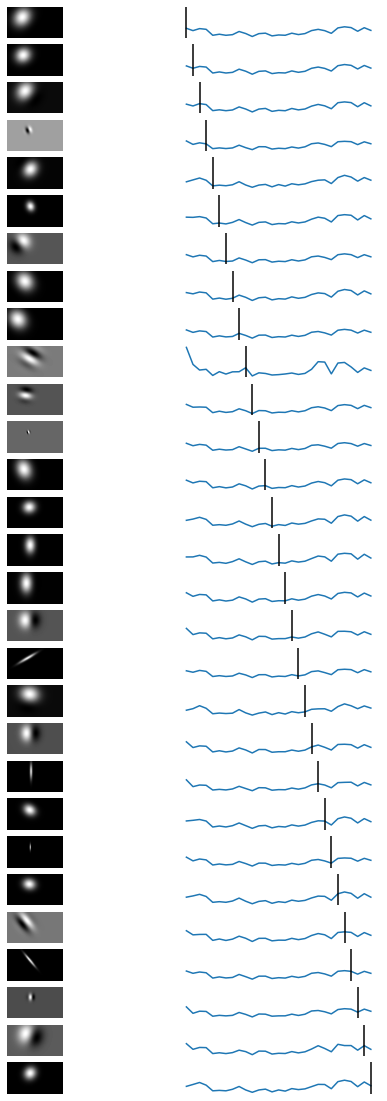

In [55]:
fig, axs = plt.subplots(29, 2, figsize=(8, 20), sharey='col')

responses = []
for ax, unit in zip(axs, range(29)):
    best_gabor_img = gabor_set.get_image_from_params(best_params_list[unit])
    
    image = torch.tensor(best_gabor_img).expand(1, 1, h, w).float().cuda()
    res = model(image, data_key=data_key).detach().cpu().numpy().squeeze()
    responses.append(res)

    ax[0].imshow(best_gabor_img, cmap='gray')
    ax[0].axis('off')
    
    ax[1].plot(res[:29])
    ax[1].axvline(unit, c='k')
    ax[1].axis('off')

axs[-1][0].axis('off')
plt.savefig('responses.png', dpi=300)
plt.show()

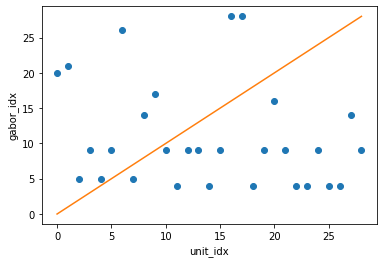

In [47]:
plt.scatter(np.arange(29), np.array(responses).argmax(0)[:29])
plt.plot(np.arange(29), np.arange(29), c='tab:orange')
plt.xlabel('unit_idx')
plt.ylabel('gabor_idx')
plt.show()

In [48]:
images = np.random.randn(100, 1, h, w)
images = torch.tensor(images).float()

output = model(images, data_key=data_key).detach().numpy()

mean_random_activations = []
std_random_activations = []
for unit in range(n_units):
    mean_random_activations.append(np.mean(output[:, unit]))
    std_random_activations.append(np.std(output[:, unit]))

responses_per_unit = []
for unit in range(n_units):
    res_opt = np.array(responses)[unit, unit]
    res_0 = np.array(responses)[gabor_idx_desc[unit, 0], unit]
    res_1 = np.array(responses)[gabor_idx_desc[unit, 1], unit]
    res_2 = np.array(responses)[gabor_idx_desc[unit, 2], unit]

    responses_per_unit.append((res_opt, res_0, res_1, res_2))
responses_per_unit = np.array(responses_per_unit)

gabor_idx_desc = np.array(responses).argsort(0)[::-1]

fig, axs = plt.subplots(n_units, 5, figsize=(5 * 3, n_units * 2))

for unit in range(n_units):
    if unit == 0:
        axs[unit, 0].set_title('1')
        axs[unit, 1].set_title('2')
        axs[unit, 2].set_title('3')
        axs[unit, 3].set_title('Search Result')
        axs[unit, 4].set_title('vs. random image')

    for idx, gabor_idx in enumerate(gabor_idx_desc[unit, :3]):
        img = gabor_set.get_image_from_params(best_params_list[gabor_idx])
        axs[unit, idx].imshow(img, cmap='gray')
        axs[unit, idx].axis('off')
        
    img = gabor_set.get_image_from_params(best_params_list[unit])
    axs[unit, 3].imshow(img, cmap='gray')
    axs[unit, 3].axis('off')
    
    axs[unit, 4].errorbar([unit], [mean_random_activations[unit]], yerr=[std_random_activations[unit]], fmt='o', c='tab:blue', label='rnd')
    axs[unit, 4].scatter([unit], responses_per_unit[unit, 1], c='silver', label='1')
    axs[unit, 4].scatter([unit], responses_per_unit[unit, 2], c='#aaa', label='2')
    axs[unit, 4].scatter([unit], responses_per_unit[unit, 3], c='gray', label='3')
    axs[unit, 4].scatter([unit], responses_per_unit[unit, 0], c='tab:orange', label='opt')
    axs[unit, 4].set_yticks([])
    axs[unit, 4].set_xticks([])
    
    if unit == 0:
        axs[unit, 4].legend()

plt.savefig('top3_gabors.png', dpi=300)
plt.show()



RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

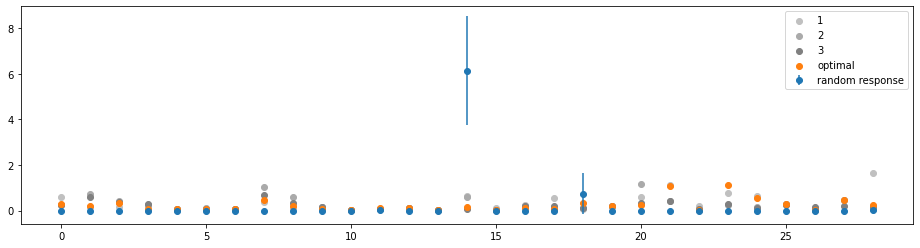

In [49]:
gabor_idx_desc = np.array(responses).argsort(0)[::-1]

images = np.random.randn(100, 1, h, w)
images = torch.tensor(images).float().cuda() * 10

output = model(images, data_key=data_key).detach().cpu().numpy()

mean_random_activations = []
std_random_activations = []
for unit in range(n_units):
    mean_random_activations.append(np.mean(output[:, unit]))
    std_random_activations.append(np.std(output[:, unit]))

plt.figure(figsize=(16, 4))
plt.errorbar(np.arange(29), mean_random_activations[:29], yerr=std_random_activations[:29], fmt='o', c='tab:blue', label='random response')

responses_per_unit = []
for unit in range(29):
    res_opt = np.array(responses)[unit, unit]
    res_0 = np.array(responses)[gabor_idx_desc[unit, 0], unit]
    res_1 = np.array(responses)[gabor_idx_desc[unit, 1], unit]
    res_2 = np.array(responses)[gabor_idx_desc[unit, 2], unit]

    responses_per_unit.append((res_opt, res_0, res_1, res_2))
responses_per_unit = np.array(responses_per_unit)

plt.scatter(np.arange(29), responses_per_unit[:29, 1], c='silver', label='1')
plt.scatter(np.arange(29), responses_per_unit[:29, 2], c='#aaa', label='2')
plt.scatter(np.arange(29), responses_per_unit[:29, 3], c='gray', label='3')
plt.scatter(np.arange(29), responses_per_unit[:29, 0], c='tab:orange', label='optimal')


# plt.xlim(-0.5, 0.5)
plt.legend()
plt.savefig('vs_random.png', dpi=300)
plt.show()

In [42]:
from nnvision.utility.measures import get_correlations
test_correlation = get_correlations(model, dataloaders["test"], device='cuda')
print(test_correlation.mean())

0.33589366
